In [1]:
import os 
import pickle
from glob import glob
import requests
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
import numpy as np
from showit import image
from skimage import img_as_float32
import seaborn as sns 
from skimage.feature import peak_local_max
from sympy import Point, Line, Segment
import pandas as pd 

from starfish import ImageStack
from starfish.types import Indices
from starfish.image import Filter
from starfish.types._spot_attributes import SpotAttributes
from starfish.spots import SpotFinder

%matplotlib inline
%load_ext autoreload
%autoreload 2

aws_data_path = 's3://czi.starfish.data.public/browse/raw/20180912/osmFISH/'
_im_path = os.path.join(aws_data_path, 'images')
_res_path = os.path.join(aws_data_path, 'results')
fov_num = 33
im_path = 'images'
res_path = 'results'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load pysmFISH results

In [2]:
!aws s3 cp $_im_path/ ./images --exclude "*" --include "*$fov_num*" --recursive 2>&1 > /dev/null

In [3]:
!aws s3 cp $_res_path/ ./results --exclude "*" --include "*$fov_num*" --recursive 2>&1 > /dev/null

In [4]:
def load_image_stack(fov_num):
    ims = glob(os.path.join(im_path, '*.npy'))
    im = np.load([i for i in ims if str(fov_num) in i][0])   
    stack = np.zeros((1, 1, 45, 2048, 2048))
    stack[0,0,:,:,:] = img_as_float32(im)
    stack = img_as_float32(stack)

    return ImageStack.from_numpy_array(stack)

def load_results(fov_num):
    pkls = glob(os.path.join(res_path, '*.pkl'))
    pkl = [p for p in pkls if str(fov_num) in p][0]
    with open(pkl, 'rb') as f:
        res = pickle.load(f)
    
    for k, v in res.items():
        if type(v) is np.float64 or type(v) is np.int64 or type(v) is np.int:
            print(k, v)

    return res

def selected_peaks(res, redo_flag = False):

    if not redo_flag:
        sp = pd.DataFrame({'y':res['selected_peaks'][:,0],
                           'x':res['selected_peaks'][:,1],
                           'selected_peaks_int': res['selected_peaks_int']
                          })
    else:
        p = peaks(res)
        coords = p[p.thr_array==res['selected_thr']].peaks_coords
        coords = coords.values[0]
        sp = pd.DataFrame({'x':coords[:,0], 'y':coords[:,1]})
        
    return sp

def peaks(res):
    p = pd.DataFrame({'thr_array':res['thr_array'],
              'peaks_coords':res['peaks_coords'],
              'total_peaks':res['total_peaks']
             })
    return p

res = load_results(fov_num)
sp = selected_peaks(res, redo_flag=False)
p = peaks(res)

selected_thr 0.009161814025600973
calculated_thr 0.009161814025600973
thr_idx 2
stringency 0


In [5]:
psymFISH_thresh = res['selected_thr']

In [6]:
stack = load_image_stack(fov_num)

/Users/ajc/projects/spacetx/starfish/.venv/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to float32
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 45/45 [00:00<00:00, 509.53it/s]


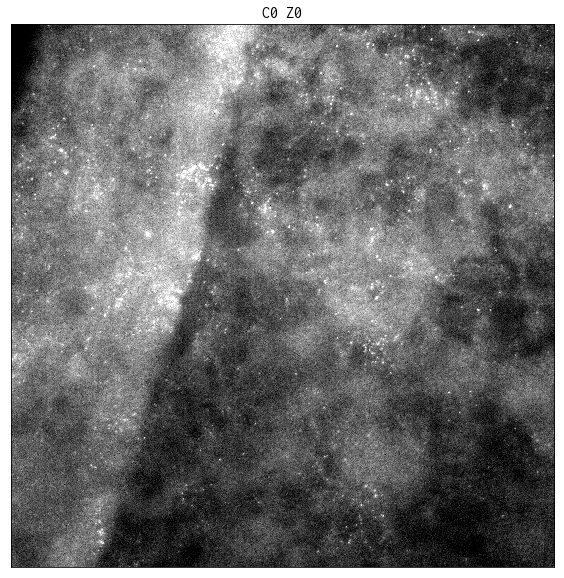

<function starfish.imagestack.imagestack.ImageStack._show_matplotlib_inline.<locals>.display_slice(plane_index=0)>

In [7]:
stack.show_stack({Indices.ROUND: 0}, rescale=True)

# Re-produce pysmFISH Results

## Filtering code

In [8]:
from starfish.image import Filter

ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
lp = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)

stack_hp = ghp.run(stack, in_place=False)
stack_hp_lap = lp.run(stack_hp, in_place=False)

1it [00:06,  6.83s/it]
1it [00:05,  5.42s/it]


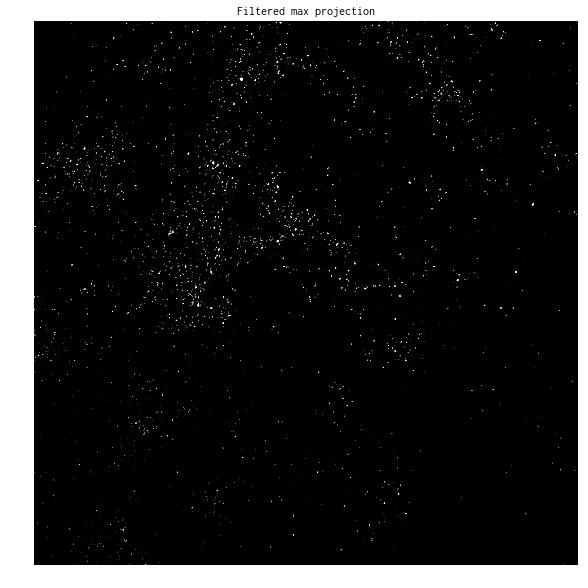

In [9]:
mp = stack_hp_lap.max_proj(Indices.Z)[0,0,:,:]

plt.figure(figsize=(10,10))
plt.imshow(mp, cmap = 'gray', vmin=np.percentile(mp, 98), vmax=np.percentile(mp, 99.9))
plt.title('Filtered max projection')
plt.axis('off');

### Spot Finding

In [10]:
min_distance = 6
stringency = 0
min_obj_area = 6 
max_obj_area = 600

# TODO this will go away once ImageStack.max_proj returns an ImageStack
stack = ImageStack.from_numpy_array(np.expand_dims(np.expand_dims(np.expand_dims(mp, 0), 0), 0))

lmp = SpotFinder.LocalMaxPeakFinder(
    min_distance=min_distance, 
    stringency=stringency, 
    min_obj_area=min_obj_area, 
    max_obj_area=max_obj_area
)
lmp_res = lmp.run(stack)

  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:10<00:07,  5.56it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...


### Spot finding QA

In [11]:
lmp_res

<xarray.IntensityTable (features: 1655, c: 1, r: 1)>
array([[[0.018725]],

       [[0.016324]],

       ...,

       [[0.015083]],

       [[0.016597]]])
Coordinates:
    x         (features) int64 419 366 1155 382 207 889 261 346 1271 340 326 ...
    y         (features) int64 2047 2007 1991 1986 1983 1980 1976 1958 1956 ...
    z         (features) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    radius    (features) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  * features  (features) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * c         (c) int64 0
  * r         (r) int64 0

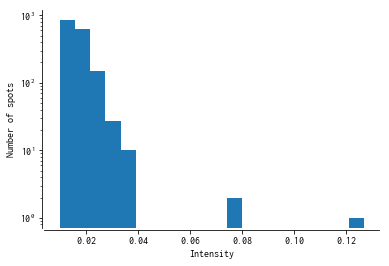

In [12]:
plt.hist(lmp_res.data[:,0,0], bins=20)
sns.despine(offset=2)
plt.yscale('log')
plt.xlabel('Intensity')
plt.ylabel('Number of spots');

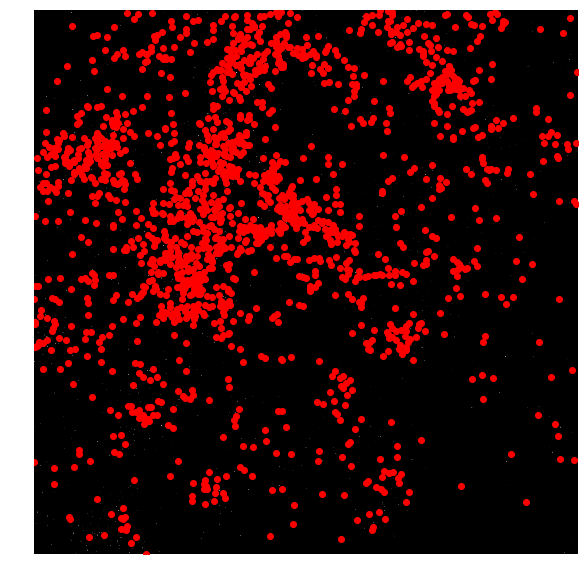

In [13]:
mp = stack_hp_lap.max_proj(Indices.Z)[0,0,:,:]

plt.figure(figsize=(10,10))
plt.imshow(mp, cmap = 'gray', vmin=np.percentile(mp, 98), vmax=np.percentile(mp, 99.9))
plt.plot(lmp_res.x, lmp_res.y, 'or')
plt.axis('off');

## Compare to pySMFISH peak calls

Starfish finds 41 fewer spots


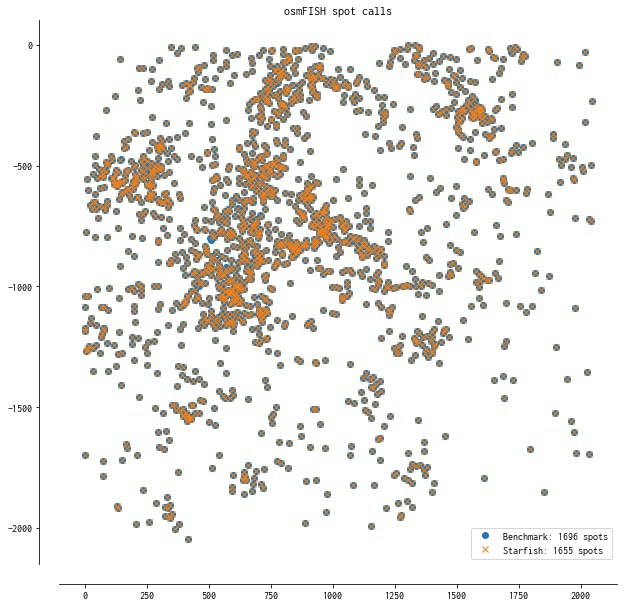

In [14]:
num_spots_simone = len(sp)
num_spots_starfish = len(lmp_res)

plt.figure(figsize=(10,10))
plt.plot(sp.x, -sp.y, 'o')
sns.despine(offset=20)
plt.plot(lmp_res.x, -lmp_res.y, 'x')

plt.legend(['Benchmark: {} spots'.format(num_spots_simone), 
            'Starfish: {} spots'.format(num_spots_starfish)])
plt.title('osmFISH spot calls');

print("Starfish finds {} fewer spots".format(num_spots_simone-num_spots_starfish))